# 1. Import and setup

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [104]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [105]:
RANDOM_STATE=42

In [106]:
# Helper function

"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours, features_kde):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

# 2. Read dataset

In [107]:
df = pd.read_csv('../dataset/digital_final_27th_Oct.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,22698313,0,F,89,2164-09-06T02:23:00,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,29562026,0,F,84,NaN,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,21607777,0,F,37,NaN,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,25233292,0,M,47,NaN,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,24214772,0,M,22,NaN,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [108]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    249
Dead        62
Name: count, dtype: int64

In [109]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

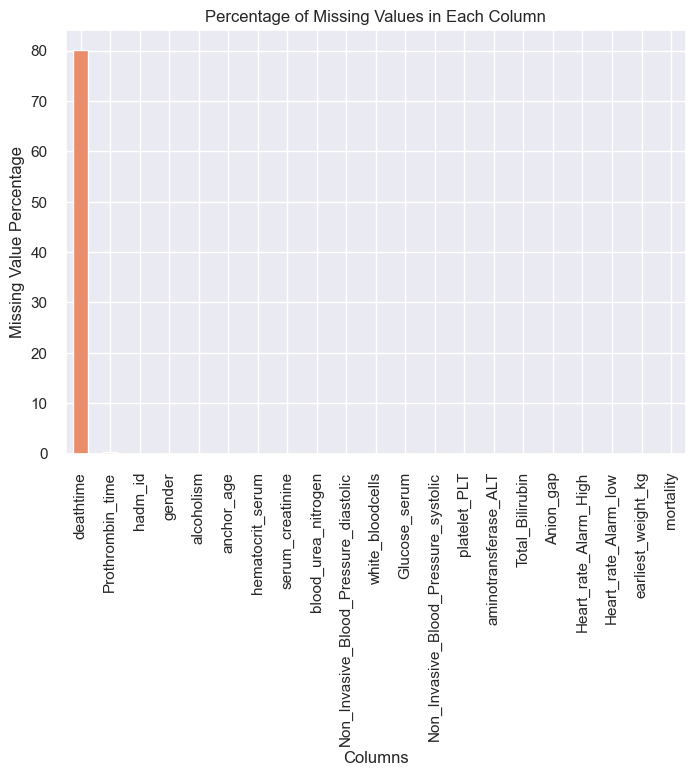

In [110]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [111]:
missing_columns = missing_percentage.sort_values(ascending=False)[:1]
missing_columns

deathtime    80.064309
dtype: float64

In [112]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead
1,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive
2,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive
3,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive
4,24214772,0,M,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive


In [113]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.00    310
0.05      1
Name: count, dtype: int64

In [114]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,310.00,311.00,311.00,311.00,311.00,311.00,311.00
mean,24968797.93,0.13,59.98,32.45,31.84,1.81,123.07,70.53,13.82,152.17,221.18,17.75,195.26,2.76,15.94,125.37,52.75,80.41
std,2848398.04,0.34,17.64,7.46,27.77,1.89,27.23,19.79,11.79,92.15,142.87,10.48,641.63,5.56,5.38,10.08,5.98,22.56
min,20009550.00,0.00,22.00,16.60,1.00,0.10,57.00,25.00,0.20,36.00,6.00,8.80,2.00,0.00,5.00,100.00,40.00,32.00
25%,22547487.50,0.00,48.00,27.30,14.00,0.80,103.00,56.00,7.20,103.00,117.50,13.40,18.00,0.50,13.00,120.00,50.00,64.95
50%,24961541.00,0.00,61.00,31.40,23.00,1.10,121.00,68.00,11.30,133.00,198.00,15.40,35.00,1.00,15.00,120.00,50.00,78.00
75%,27380606.50,0.00,73.00,37.10,40.50,2.10,140.50,83.00,17.60,168.00,290.00,18.58,106.00,2.50,18.00,130.00,60.00,93.00
max,29995505.00,1.00,91.00,54.30,163.00,20.40,259.00,142.00,156.20,817.00,942.00,150.00,8805.00,53.10,44.00,170.00,90.00,166.60


In [115]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,311,311
unique,2,2
top,M,Survive
freq,163,249


In [116]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  311
Number of duplication 0


In [117]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

In [118]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

# 4. Preprocessing

In [119]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,0,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [120]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,mortality
0,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,0,0
1,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,0,1
2,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,0,1
3,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,1,1
4,0,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,1,1


In [121]:
X = X.fillna(X.median())

In [122]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.38418938,  1.6476941 , -1.68594643, ..., -1.08353743,
        -1.04945288, -2.0040282 ],
       [-0.38418938,  1.36382923, -1.33676957, ..., -0.10244702,
        -1.04945288,  0.49899497],
       [-0.38418938, -1.30450056, -0.39667804, ..., -1.25223171,
        -1.04945288,  0.49899497],
       ...,
       [-0.38418938,  0.05805082,  0.00621834, ..., -0.09356837,
         0.95287746, -2.0040282 ],
       [-0.38418938,  1.30705625, -0.0340713 , ..., -1.17232389,
        -1.04945288,  0.49899497],
       [-0.38418938, -0.56645189, -1.04131223, ...,  0.03073268,
         0.95287746,  0.49899497]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [123]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)].reset_index(drop=True)
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 277


array([[-0.38418938,  1.6476941 , -1.68594643, ..., -1.08353743,
        -1.04945288, -2.0040282 ],
       [-0.38418938,  1.36382923, -1.33676957, ..., -0.10244702,
        -1.04945288,  0.49899497],
       [-0.38418938, -1.30450056, -0.39667804, ..., -1.25223171,
        -1.04945288,  0.49899497],
       ...,
       [ 2.60288302, -1.53159245,  0.77172144, ...,  0.11507982,
         0.95287746,  0.49899497],
       [-0.38418938,  0.22836975, -0.18179997, ...,  0.43027176,
         0.95287746,  0.49899497],
       [-0.38418938,  1.30705625, -0.0340713 , ..., -1.17232389,
        -1.04945288,  0.49899497]])

# 5. K-Means


## 5.1. Finding optimal cluster

#### Manual

In [124]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [125]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

137586787.5880386

In [126]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([89.92040271, 90.67417078, 91.29146083, 91.78500028, 92.19089696,
       92.41995737, 92.63349033, 92.77004697, 92.95363261, 93.14202411,
       93.277456  , 93.42194819, 93.51951285])

Text(0.5, 1.0, 'Total Variance Explained')

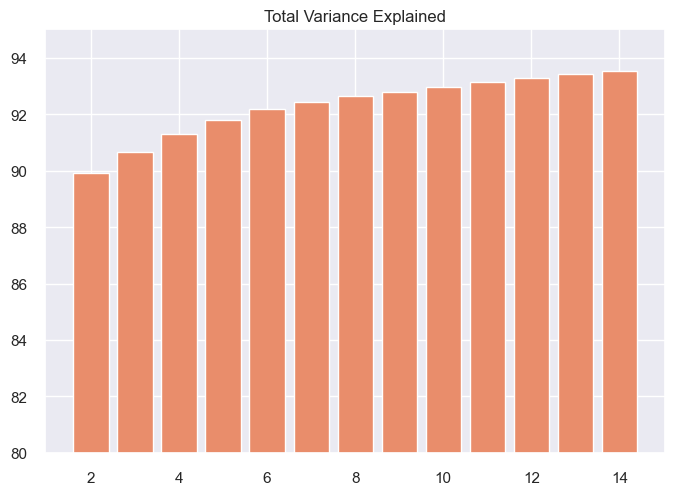

In [127]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

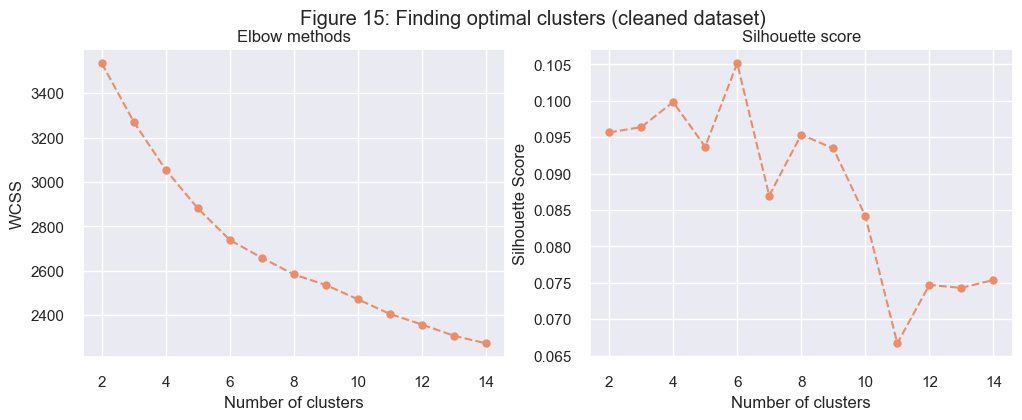

In [128]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 15: Finding optimal clusters (cleaned dataset)")
plt.show()

#### On Yellowbrick

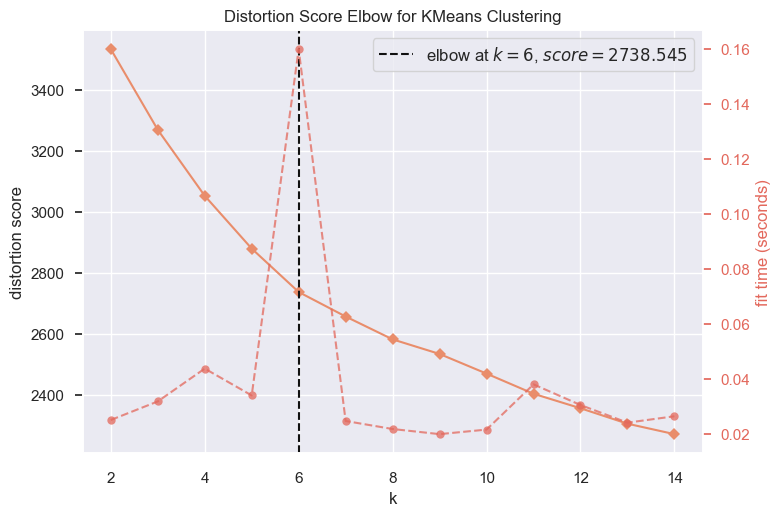

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [145]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [130]:
optimal_cluster = 6

## 5.2. Fitting the model

In [131]:
# Fit model
kmeans = KMeans(n_clusters=optimal_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,...,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead,1
1,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,...,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive,5
2,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,...,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive,5
3,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,...,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive,3
4,24214772,0,M,22,43.0,11.0,0.9,148.0,80.0,18.1,...,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive,0


In [132]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {optimal_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 6 clusters, resulting on 2738.54 WCSS and 0.11 silhouette score


In [133]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,4.651163e-02,59.348837,41.297674,26.302326,1.379070,153.418605,92.279070,14.148837,167.046512,214.186047,16.646512,131.093023,1.974419,15.720930,127.325581,53.023256,88.444186,0.813953,7.906977e-01
1,2.775558e-17,71.142857,29.082857,33.914286,1.688571,111.514286,58.685714,15.808571,135.371429,227.457143,17.325714,136.228571,2.314286,15.400000,125.285714,51.142857,77.840000,0.485714,-2.220446e-16
2,1.000000e+00,46.387097,33.212903,22.870968,1.422581,120.612903,75.193548,10.835484,146.612903,133.193548,17.148387,118.032258,4.335484,16.451613,126.774194,54.193548,81.377419,0.612903,9.354839e-01
3,5.000000e-02,56.600000,27.960000,84.100000,5.200000,129.150000,73.550000,13.705000,127.350000,162.050000,20.735000,112.000000,3.650000,20.500000,122.500000,51.000000,76.245000,0.450000,8.000000e-01
4,2.775558e-17,65.161290,31.079032,29.241935,1.574194,109.338710,61.306452,12.506452,148.870968,232.000000,16.654839,112.016129,1.696774,14.161290,123.548387,52.338710,92.609677,0.967742,1.000000e+00
5,2.775558e-17,59.697674,31.501163,17.755814,1.059302,120.220930,68.267442,12.577907,132.906977,243.093023,15.358140,124.476744,1.791860,14.348837,124.302326,53.023256,65.660465,0.023256,1.000000e+00


## 5.3. Visualization

### Clusters Visualization

In [134]:
df_clean.cluster.value_counts()

cluster
5    86
4    62
0    43
1    35
2    31
3    20
Name: count, dtype: int64

In [135]:
def stat_cum(cluster):
    cluster0 = df_clean[df_clean.cluster == cluster]
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    print(f"Mortality rate is {round(100* len(cluster0[cluster0.mortality == 'Dead']) / len(cluster0),2)}")
    display(round(cluster0.describe(),2))

In [136]:
for i in range(5):
    print("====================== Cluster %s =========================" % (i))
    stat_cum(i)

====================== Cluster 0 =========================
Percentage of women and men (respectively) 18.6 and 81.4
Mortality rate is 20.93


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00
mean,24885747.53,0.05,59.35,41.30,26.30,1.38,153.42,92.28,14.15,167.05,214.19,16.65,131.09,1.97,15.72,127.33,53.02,88.44
std,2502451.87,0.21,16.55,7.39,14.99,0.83,20.96,15.03,6.05,83.86,89.04,7.00,230.72,2.40,3.68,10.93,6.28,20.58
min,20238313.00,0.00,22.00,23.20,4.00,0.50,108.00,59.00,3.00,45.00,25.00,9.70,2.00,0.20,6.00,120.00,40.00,54.00
25%,22798121.50,0.00,49.00,36.65,18.00,0.85,142.50,82.00,10.70,117.50,166.00,13.35,23.00,0.60,14.00,120.00,50.00,75.65
50%,24519724.00,0.00,63.00,41.40,23.00,1.10,154.00,92.00,13.70,145.00,210.00,14.50,38.00,1.00,15.00,120.00,50.00,83.90
75%,26959793.00,0.00,70.00,45.95,33.00,1.45,163.00,100.00,17.80,175.00,258.50,17.20,97.00,2.25,18.00,130.00,60.00,99.60
max,29955825.00,1.00,91.00,54.30,70.00,4.60,201.00,137.00,29.30,464.00,461.00,49.00,1201.00,12.60,25.00,160.00,70.00,154.50


====================== Cluster 1 =========================
Percentage of women and men (respectively) 51.43 and 48.57
Mortality rate is 100.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,35.00,35.0,35.00,35.00,35.00,35.00,35.00,35.00,35.00,35.00,35.00,34.00,35.00,35.00,35.00,35.00,35.00,35.00
mean,24625254.77,0.0,71.14,29.08,33.91,1.69,111.51,58.69,15.81,135.37,227.46,17.38,136.23,2.31,15.40,125.29,51.14,77.84
std,2835762.78,0.0,16.54,4.70,21.74,1.20,21.84,17.80,11.20,56.89,133.02,5.10,332.13,3.49,4.13,11.69,6.19,20.01
min,20189200.00,0.0,23.00,19.90,10.00,0.50,57.00,26.00,0.30,57.00,34.00,11.90,7.00,0.20,10.00,100.00,40.00,50.00
25%,22155283.00,0.0,61.00,26.90,19.50,0.85,100.00,46.00,8.10,93.00,105.00,14.45,17.00,0.50,13.00,120.00,50.00,67.15
50%,24540175.00,0.0,73.00,28.80,26.00,1.30,111.00,56.00,12.80,130.00,202.00,16.30,40.00,0.70,14.00,120.00,50.00,75.90
75%,26979584.50,0.0,85.50,31.55,42.50,1.95,123.50,66.50,20.35,160.50,308.00,18.33,84.50,1.90,17.00,130.00,55.00,84.65
max,29667230.00,0.0,91.00,39.10,108.00,5.80,154.00,107.00,48.60,296.00,536.00,39.20,1789.00,16.70,26.00,160.00,60.00,141.40


====================== Cluster 2 =========================
Percentage of women and men (respectively) 38.71 and 61.29
Mortality rate is 6.45


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,31.00,31.0,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00
mean,25477688.90,1.0,46.39,33.21,22.87,1.42,120.61,75.19,10.84,146.61,133.19,17.15,118.03,4.34,16.45,126.77,54.19,81.38
std,3031730.07,0.0,11.01,7.74,16.20,1.10,23.33,17.66,5.32,60.00,90.05,5.36,322.55,5.44,6.82,8.90,5.64,17.24
min,20561449.00,1.0,27.00,16.90,3.00,0.40,73.00,45.00,2.90,66.00,18.00,11.00,7.00,0.20,7.00,120.00,50.00,51.90
25%,22680663.00,1.0,39.50,27.85,10.00,0.75,107.00,63.00,7.30,104.00,78.50,12.95,23.50,0.75,12.50,120.00,50.00,68.30
50%,25913442.00,1.0,47.00,32.30,20.00,1.00,120.00,76.00,9.70,140.00,124.00,15.00,31.00,1.80,15.00,120.00,50.00,78.50
75%,27887110.50,1.0,54.00,39.20,32.50,1.65,135.50,84.50,13.20,176.50,151.00,19.80,71.50,5.95,17.50,130.00,60.00,93.80
max,29762400.00,1.0,65.00,47.30,67.00,4.60,185.00,109.00,26.70,288.00,487.00,29.60,1773.00,21.20,34.00,150.00,70.00,113.50


====================== Cluster 3 =========================
Percentage of women and men (respectively) 55.0 and 45.0
Mortality rate is 20.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,25075864.75,0.05,56.60,27.96,84.10,5.20,129.15,73.55,13.70,127.35,162.05,20.74,112.00,3.65,20.50,122.50,51.00,76.24
std,3336994.46,0.22,18.26,5.44,27.15,1.73,33.13,23.37,8.18,58.03,122.68,9.17,270.71,5.08,4.96,7.16,5.53,20.14
min,20009550.00,0.00,24.00,17.40,42.00,1.80,83.00,44.00,5.00,69.00,9.00,11.50,5.00,0.20,13.00,100.00,40.00,40.00
25%,22743426.50,0.00,46.75,25.02,65.75,4.42,97.75,55.75,7.07,83.00,73.75,14.18,14.00,0.30,17.00,120.00,50.00,61.15
50%,25357058.00,0.00,58.50,27.30,83.50,5.45,127.50,72.00,11.30,108.00,124.00,16.70,21.50,1.10,20.00,120.00,50.00,77.10
75%,27425369.00,0.00,71.25,31.10,105.25,6.35,147.00,85.00,18.42,144.75,254.25,25.75,47.75,4.90,23.25,130.00,50.00,91.42
max,29742461.00,1.00,81.00,43.70,126.00,7.90,200.00,131.00,33.10,296.00,495.00,41.30,1173.00,18.80,30.00,130.00,60.00,107.60


====================== Cluster 4 =========================
Percentage of women and men (respectively) 3.23 and 96.77
Mortality rate is 0.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,62.00,62.0,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00,62.00
mean,25176597.23,0.0,65.16,31.08,29.24,1.57,109.34,61.31,12.51,148.87,232.00,16.65,112.02,1.70,14.16,123.55,52.34,92.61
std,2868923.86,0.0,14.86,6.34,18.34,0.99,20.44,13.05,8.12,73.25,147.81,5.21,252.50,1.95,3.27,9.43,4.94,21.00
min,20084622.00,0.0,25.00,16.60,6.00,0.50,60.00,37.00,0.40,64.00,6.00,10.30,5.00,0.00,5.00,100.00,40.00,55.50
25%,23081664.25,0.0,56.50,26.60,15.00,0.90,94.00,51.00,6.70,103.00,121.50,13.15,17.25,0.60,12.00,120.00,50.00,78.00
50%,24887499.00,0.0,68.50,31.35,24.00,1.30,108.50,59.00,9.30,126.00,200.50,15.30,31.50,1.05,14.00,120.00,50.00,87.70
75%,27365555.50,0.0,76.00,34.08,37.75,1.95,124.00,70.00,19.00,174.00,289.00,18.25,97.50,1.95,16.00,120.00,58.75,104.98
max,29995505.00,0.0,91.00,45.90,84.00,5.50,154.00,98.00,29.00,450.00,645.00,41.90,1597.00,11.20,20.00,150.00,60.00,149.00


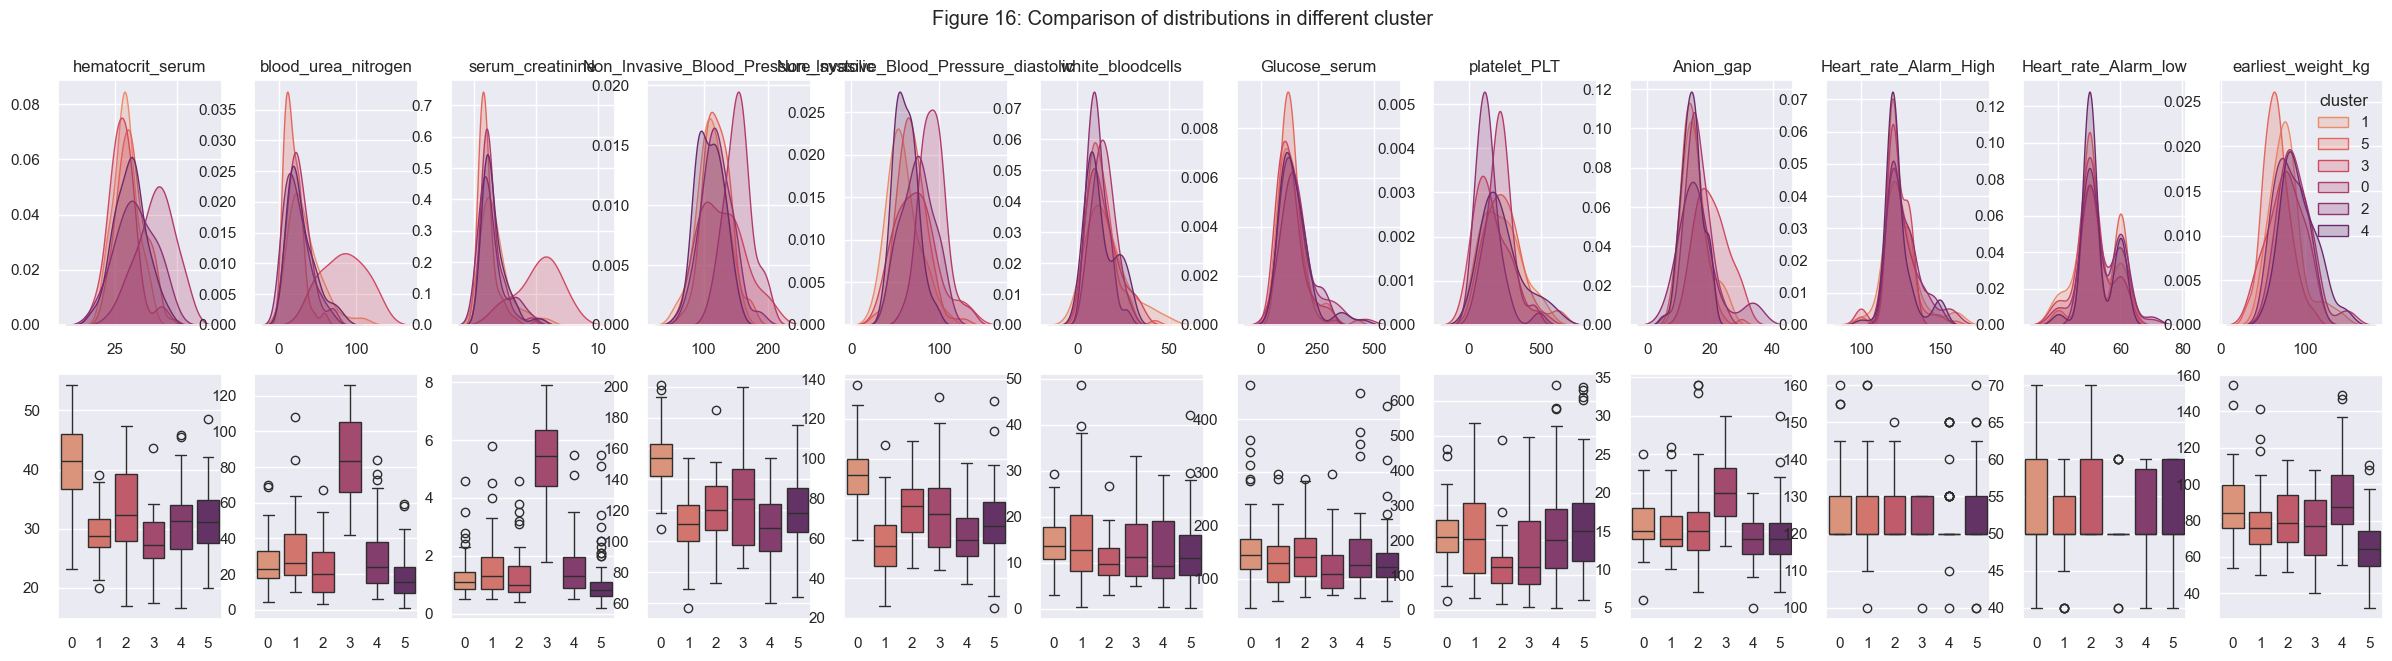

{'hematocrit_serum': 0.027053491756451605,
 'blood_urea_nitrogen': 4.2075331884918804e-07,
 'serum_creatinine': 0.0018915351344509313,
 'Non_Invasive_Blood_Pressure_systolic': 0.04340147205914891,
 'Non_Invasive_Blood_Pressure_diastolic': 0.006100466685650638,
 'white_bloodcells': 0.06285544636143771,
 'Glucose_serum': 0.8226081078546782,
 'platelet_PLT': 0.5625537940808238,
 'Anion_gap': 0.17779325773320723,
 'Heart_rate_Alarm_High': 0.6149650758255709,
 'Heart_rate_Alarm_low': 0.1048096306089662,
 'earliest_weight_kg': 0.0005006799380810213}

In [137]:
plot_mean_difference(df_clean, 'cluster', "Figure 16: Comparison of distributions in different cluster", colours=palette, features_kde=features_kde)

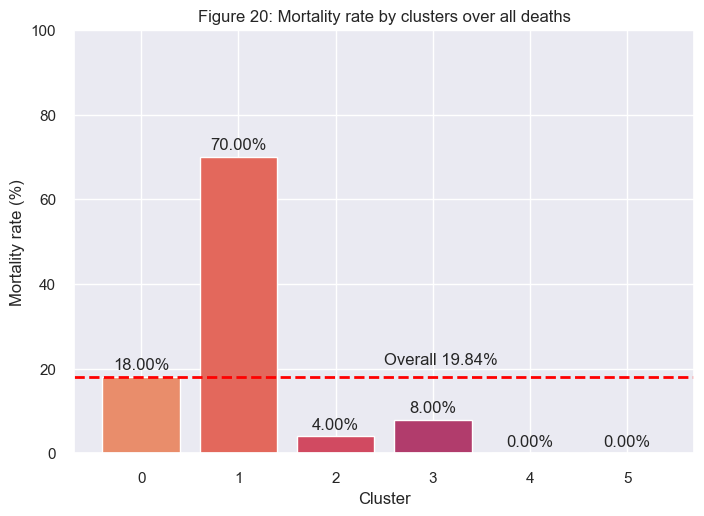

In [147]:
# Mortality rate in each cluster
mortality_cluster = []

for c in sorted(df_clean['cluster'].unique()):
    sub = df_clean[df_clean.cluster == c]
    mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / df_clean.mortality.value_counts()['Dead'])

plt.bar(["0","1","2","3","4","5"], mortality_cluster, color=palette)
plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Overall 19.84%', xy=(0, 20), xytext=(2.5, 21))

for i, rate in enumerate(mortality_cluster):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

plt.xlabel("Cluster")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 20: Mortality rate by clusters over all deaths")
plt.ylim([0,100])

plt.show()

### On PCA

In [139]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_cleaned)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca['cluster'] = df_clean['cluster']
X_pca

,PC1,PC2,PC3,cluster
0,-2.450041,0.980380,-1.978989,1
1,-0.565437,-0.699496,-0.561575,5
2,-1.555885,-0.968665,0.253054,5
3,0.708821,3.375716,0.222916,3
4,2.330734,-0.143030,0.008252,0
...,...,...,...,...
272,-1.333672,1.051397,-0.493342,3
273,1.185549,-1.161565,-1.100051,5
274,2.142093,0.258664,2.627356,2
275,0.506146,2.438278,-0.274836,3


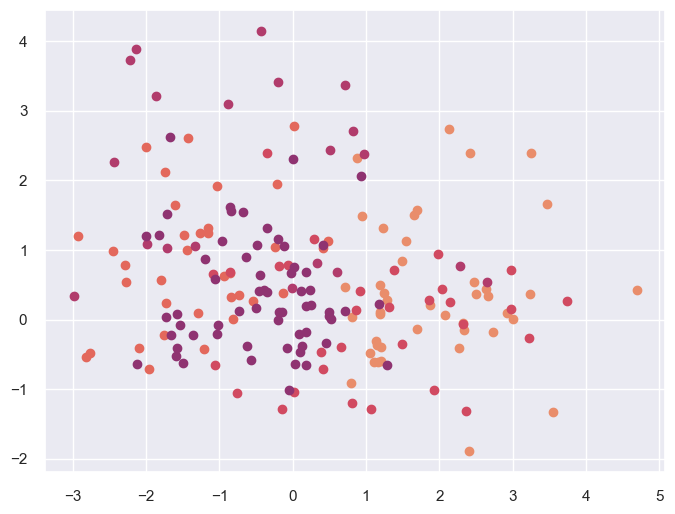

In [144]:
plt.figure(figsize=(8, 6))
for cluster in range(5):
    cluster_data = X_pca[X_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=palette[cluster])

In [143]:
import plotly.express as px

fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="Figure 12:", color_discrete_sequence=palette)
fig.show()

# 6. Discussion

## 6.1. Property of the clusters

## 6.2. Relation to Outcomes

Female, 40, fat, fertile.